In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal as sig
from scipy import ndimage
import glob
import os

In [2]:
def read_and_grayscale_images(foldername):
    image_dict={}
    image_list=[]
    folders = glob.glob(foldername+'/*')
    scene=1
    image_index=-1
    for folder in folders:
        for file in glob.glob(folder+'/*.jpg'):
            image = cv2.imread(file)
            imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)
            image_index+=1
            image_list.append(gray)
            image_dict[image_index]=scene
        scene+=1
    return image_dict,image_list

In [3]:
def resize_images(image):
    row,column=image.shape
    if row>=column:
        column=int((column/row)*1024)
        row=1024
    else:
        row=int((row/column)*1024)
        column=1024
        
    resized = cv2.resize(image, (row,column), interpolation = cv2.INTER_AREA)
    return resized

In [4]:
def orb_features(image):
    kp, des = orb.detectAndCompute(image,None)
    return des

In [5]:
def sift_features(image):
    kp, des = sift.detectAndCompute(image,None)
    return des

In [6]:
def two_image_distance(image_des1,image_des2,k=10):
    keypoints_distance=np.ones(max(len(image_des1),len(image_des2)))*10000
    for i ,kp1 in enumerate(image_des1):
        for j, kp2 in enumerate(image_des2):
            dist = np.linalg.norm(kp1-kp2)
            if dist < keypoints_distance[i]:
                keypoints_distance[i]=dist
    keypoints_distance.sort() 
    return keypoints_distance

In [7]:
def all_image_keypoint_dist(size,des_list,max_matches):
    image_dist_list=np.zeros((size,size),dtype=np.ndarray)
    for i ,img1 in enumerate(des_list):
        for j, img2 in enumerate(des_list):
            if j>i:
                dist_list = two_image_distance(img1,img2)
                image_dist_list[i][j]=image_dist_list[j][i]=dist_list
        image_dist_list[i][i]=np.zeros(max_matches)
    return image_dist_list

In [8]:
def all_image_distances(size,des_list,k=10):
    image_distances=np.zeros((size,size))
    for i in range(len(des_list)):
        for j in range(len(des_list)):
            if j>i:
                image_distances[i][j]=sum(des_list[i][j][:k])  
                image_distances[j][i]=image_distances[i][j]
    return image_distances

In [9]:
def query_image(image_idx,distance_list,num_closest=5):
    closest_image_idxs=np.argsort(distance_list)
    closest_images =closest_image_idxs[:6]
    closest_images=closest_images[closest_images!=image_idx]
    return closest_images        

In [10]:
def accuracy(image_dict,image_distances,num_closest=5):
    image_accuracy=[]
    for image_idx, dist_list in enumerate(image_distances):
        closest_images= query_image(image_idx,dist_list,num_closest)     
        acc_count=0
        for idx in closest_images:
            if image_dict[idx]==image_dict[image_idx]:
                acc_count+=1
        image_accuracy.append((acc_count/5.0)*100)
    avg_img_ret_accuracy=sum(image_accuracy)/float(len(image_accuracy))
    return image_accuracy,avg_img_ret_accuracy        

In [11]:
def orb_feature_detection(image_dict,orb_image_dist_list,k,num_closest=5):
    orb_image_distances=all_image_distances(size,orb_image_dist_list,k)
    orb_per_img_acc, orb_accuracy = accuracy(image_dict,orb_image_distances,5)
    return orb_image_distances,orb_accuracy

In [12]:
def sift_feature_detection(image_dict,sift_image_dist_list,k,num_closest=5):
    sift_image_distances=all_image_distances(size,sift_image_dist_list,k)
    sift_per_img_acc, sift_accuracy = accuracy(image_dict,sift_image_distances,5)
    return sift_image_distances,sift_accuracy

### Reading and resizing images

In [13]:
image_dict,image_list=read_and_grayscale_images('Images')
size = len(image_list)

In [14]:
for image in range(len(image_list)):
    image_list[image]=resize_images(image_list[image])   

### SIFT and ORB feature detection for k=10

In [15]:
k=10

In [16]:
max_matches=100
sift = cv2.xfeatures2d.SIFT_create(nfeatures=max_matches)
orb = cv2.ORB_create(nfeatures=max_matches)

In [17]:
orb_des_list = [orb_features(image) for image in image_list]
sift_des_list = [sift_features(image) for image in image_list]

In [18]:
%time sift_image_dist_list=all_image_keypoint_dist(size,sift_des_list,max_matches)

CPU times: user 2min 16s, sys: 491 ms, total: 2min 16s
Wall time: 2min 15s


In [19]:
%time orb_image_dist_list=all_image_keypoint_dist(size,orb_des_list,max_matches)

CPU times: user 1min 55s, sys: 0 ns, total: 1min 55s
Wall time: 1min 55s


In [20]:
orb_image_distances,orb_accuracy = orb_feature_detection(image_dict,orb_image_dist_list,k,5)
sift_image_distances,sift_accuracy=sift_feature_detection(image_dict,sift_image_dist_list,k,5)

In [21]:
print("k=%d => \nSift Accuracy: %0.2f\nORB Accuracy: %0.2f"%(k,sift_accuracy,orb_accuracy))

k=10 => 
Sift Accuracy: 65.67
ORB Accuracy: 24.33


### Query one image to find top-5 similar images

In [22]:
query_img_idx=1
top_5_images_orb = query_image(query_img_idx,orb_image_distances[query_img_idx],5)
top_5_images_sift = query_image(query_img_idx,sift_image_distances[query_img_idx],5)

In [23]:
print("ORB : The top-5 images similar to image %d are :\n"%(query_img_idx),top_5_images_orb)
print("SIFT : The top-5 images similar to image %d are :\n"%(query_img_idx),top_5_images_sift)

ORB : The top-5 images similar to image 1 are :
 [35 33 22  0 39]
SIFT : The top-5 images similar to image 1 are :
 [5 0 2 3 4]


### Comparison of SIFT and ORB

In [24]:
k_lst = [1,5,10,20,40,60,80,max_matches]

In [25]:
orb_accuracy_list=[]
sift_accuracy_list=[]
for k_ in k_lst:
    orb_image_distances,orb_accuracy = orb_feature_detection(image_dict,orb_image_dist_list,k_,5)
    orb_accuracy_list.append(orb_accuracy)
    sift_image_distances,sift_accuracy = sift_feature_detection(image_dict,sift_image_dist_list,k_,5)
    sift_accuracy_list.append(sift_accuracy)

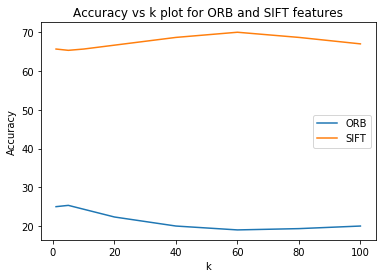

In [26]:
plt.plot(k_lst, orb_accuracy_list, label='ORB')
plt.plot(k_lst, sift_accuracy_list, label='SIFT')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs k plot for ORB and SIFT features')
plt.show()

### SIFT performs better than ORB in terms of accuracy.